##  Notebook 2 of 5
# Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data
### Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt
##### Fraunhofer IIS/EAS, Fraunhofer Institute for Integrated Circuits, Division Engineering of Adaptive Systems, Dresden, Germany

This Jupyter Notebook is part of a paper submission to the 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020. The notebook is the second one in a series of five freely available notebooks. It contains Python code fragments which were used to get the classifications results described within the ETFA paper. 

## Approach 1: Convolutional Neural Network on Raw Sensor Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

## Reading Measurement Data and Preprocessing

In [4]:
# Option a) local file contains a small subset of the entire dataset
url = '../data/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
#use_reference_models = True
#model_path = '../models/reference'

# Option d) all models will be trained again
use_reference_models = False
model_path = '../models'

In [5]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

In [6]:
skip = 50000
data0D = data0D.iloc[skip:,:]
data1D = data0D.iloc[skip:,:]
data2D = data0D.iloc[skip:,:]
data3D = data0D.iloc[skip:,:]
data4D = data0D.iloc[skip:,:]
data0E = data0E.iloc[skip:,:]
data1E = data0E.iloc[skip:,:]
data2E = data0E.iloc[skip:,:]
data3E = data0E.iloc[skip:,:]
data4E = data4E.iloc[skip:,:]

At the moment only the first vibration sensor **Vibration_1** is used for the analysis. All four data streams may need to be included in the future.

In [7]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 'Vibration_1'
samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data0D[sensor], "no_unbalance")
X1,y1 = get_features(data1D[sensor], "unbalance")
X2,y2 = get_features(data2D[sensor], "unbalance")
X3,y3 = get_features(data3D[sensor], "unbalance")
X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X0_val, y0_val = get_features(data0E[sensor], "no_unbalance")
X1_val, y1_val = get_features(data1E[sensor], "unbalance")
X2_val, y2_val = get_features(data2E[sensor], "unbalance")
X3_val, y3_val = get_features(data3E[sensor], "unbalance")
X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Now the dataset for training X contains 32142 samples with 4096 values each as well as the associated label information y with 32142 labels (one label per sample). The dataset for validating the trained model X_val contains 8420 samples plus the labels y_val accordingly.

In [9]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(32142, 4096) (32142,) (8319, 4096) (8319,)


## Train-Test-Split

The dataset for training (X,y) is splitted into two subsets (X_train,y_train) and (X_test,y_test).

In [10]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28927, 4096, 1) (28927,) (3215, 4096, 1) (3215,)


## Convolutional Neural Net (CNN)

## Test with Different Layer Numbers

In [17]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

weight_for_0 = len(y)/(2*len(y[y==0]))
weight_for_1 = len(y)/(2*len(y[y==1]))
class_weight = {0: weight_for_0, 1: weight_for_1}

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 128
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 9 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 100 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*10,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 1, activation = 'sigmoid')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                 verbose=1, save_best_only=True, mode='min')
    
    classifier.compile(optimizer = Adam(lr=learning_rate), loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])

    classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint], 
                   class_weight=class_weight)
    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)

In [18]:
if not use_reference_models:
    for i in range(1,5):
        train_models(i)

W0427 18:06:07.465865 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4088, 10)          100       
_________________________________________________________________
batch_normalization_1 (Batch (None, 4088, 10)          40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4088, 10)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2042, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20420)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               26

W0427 18:06:08.583049 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 28927 samples, validate on 3215 samples
Epoch 1/100
28800/28927 [============================>.] - ETA: 0s - loss: 0.7042 - accuracy: 0.4810
Epoch 00001: val_loss improved from inf to 0.68951, saving model to ../models/cnn_1_layers.h5
28927/28927 [==============================] - 17s 602us/sample - loss: 0.7041 - accuracy: 0.4797 - val_loss: 0.6895 - val_accuracy: 0.2351
Epoch 2/100
28800/28927 [============================>.] - ETA: 0s - loss: 0.6958 - accuracy: 0.4744
Epoch 00002: val_loss improved from 0.68951 to 0.68686, saving model to ../models/cnn_1_layers.h5
28927/28927 [==============================] - 17s 601us/sample - loss: 0.6957 - accuracy: 0.4748 - val_loss: 0.6869 - val_accuracy: 0.5991
Epoch 3/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5359
Epoch 00003: val_loss improved from 0.68686 to 0.68517, saving model to ../models/cnn_1_layers.h5
28927/28927 [==============================] - 17s 594us/sample - loss: 0.6890

Epoch 28/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9993
Epoch 00028: val_loss improved from 0.61948 to 0.56333, saving model to ../models/cnn_1_layers.h5
28927/28927 [==============================] - 17s 586us/sample - loss: 0.0294 - accuracy: 0.9993 - val_loss: 0.5633 - val_accuracy: 0.8579
Epoch 29/100
28800/28927 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9999
Epoch 00029: val_loss did not improve from 0.56333
28927/28927 [==============================] - 17s 574us/sample - loss: 0.0209 - accuracy: 0.9999 - val_loss: 0.9372 - val_accuracy: 0.8802
Epoch 30/100
28800/28927 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9995
Epoch 00030: val_loss did not improve from 0.56333
28927/28927 [==============================] - 17s 598us/sample - loss: 0.0183 - accuracy: 0.9996 - val_loss: 0.9773 - val_accuracy: 0.8678
Epoch 31/100
28800/28927 [============================>.] - ETA: 0s - loss

Epoch 56/100
28864/28927 [============================>.] - ETA: 0s - loss: 9.4585e-04 - accuracy: 1.0000
Epoch 00056: val_loss did not improve from 0.56333
28927/28927 [==============================] - 17s 596us/sample - loss: 9.4553e-04 - accuracy: 1.0000 - val_loss: 1.2636 - val_accuracy: 0.8939
Epoch 57/100
28800/28927 [============================>.] - ETA: 0s - loss: 7.6440e-04 - accuracy: 1.0000
Epoch 00057: val_loss did not improve from 0.56333
28927/28927 [==============================] - 17s 591us/sample - loss: 7.6501e-04 - accuracy: 1.0000 - val_loss: 1.1678 - val_accuracy: 0.9014
Epoch 58/100
28864/28927 [============================>.] - ETA: 0s - loss: 6.3114e-04 - accuracy: 1.0000
Epoch 00058: val_loss did not improve from 0.56333
28927/28927 [==============================] - 17s 584us/sample - loss: 6.3081e-04 - accuracy: 1.0000 - val_loss: 1.3695 - val_accuracy: 0.8862
Epoch 59/100
28864/28927 [============================>.] - ETA: 0s - loss: 5.3591e-04 - accuracy

28800/28927 [============================>.] - ETA: 0s - loss: 1.2780e-04 - accuracy: 1.0000
Epoch 00083: val_loss did not improve from 0.56333
28927/28927 [==============================] - 18s 621us/sample - loss: 1.2782e-04 - accuracy: 1.0000 - val_loss: 1.3979 - val_accuracy: 0.8980
Epoch 84/100
28864/28927 [============================>.] - ETA: 0s - loss: 1.0958e-04 - accuracy: 1.0000
Epoch 00084: val_loss did not improve from 0.56333
28927/28927 [==============================] - 18s 605us/sample - loss: 1.0955e-04 - accuracy: 1.0000 - val_loss: 1.3673 - val_accuracy: 0.9014
Epoch 85/100
28864/28927 [============================>.] - ETA: 0s - loss: 9.5583e-05 - accuracy: 1.0000
Epoch 00085: val_loss did not improve from 0.56333
28927/28927 [==============================] - 17s 599us/sample - loss: 9.5510e-05 - accuracy: 1.0000 - val_loss: 1.4212 - val_accuracy: 0.8970
Epoch 86/100
28864/28927 [============================>.] - ETA: 0s - loss: 8.3945e-05 - accuracy: 1.0000
Epoc

W0427 18:34:36.329512 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0427 18:34:37.968936 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 28927 samples, validate on 3215 samples
Epoch 1/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.7143 - accuracy: 0.6646
Epoch 00001: val_loss improved from inf to 0.68954, saving model to ../models/cnn_2_layers.h5
28927/28927 [==============================] - 32s 1ms/sample - loss: 0.7142 - accuracy: 0.6636 - val_loss: 0.6895 - val_accuracy: 0.1978
Epoch 2/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.3313
Epoch 00002: val_loss improved from 0.68954 to 0.68953, saving model to ../models/cnn_2_layers.h5
28927/28927 [==============================] - 30s 1ms/sample - loss: 0.6936 - accuracy: 0.3311 - val_loss: 0.6895 - val_accuracy: 0.1994
Epoch 3/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.2426
Epoch 00003: val_loss improved from 0.68953 to 0.68952, saving model to ../models/cnn_2_layers.h5
28927/28927 [==============================] - 31s 1ms/sample - loss: 0.6935 - acc

Epoch 27/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9951
Epoch 00027: val_loss did not improve from 0.58908
28927/28927 [==============================] - 30s 1ms/sample - loss: 0.0302 - accuracy: 0.9951 - val_loss: 0.7375 - val_accuracy: 0.8933
Epoch 28/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9974
Epoch 00028: val_loss did not improve from 0.58908
28927/28927 [==============================] - 32s 1ms/sample - loss: 0.0193 - accuracy: 0.9974 - val_loss: 0.8229 - val_accuracy: 0.8939
Epoch 29/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9983
Epoch 00029: val_loss did not improve from 0.58908
28927/28927 [==============================] - 30s 1ms/sample - loss: 0.0134 - accuracy: 0.9983 - val_loss: 0.8706 - val_accuracy: 0.8821
Epoch 30/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9986
Epoch 00030: val_loss did

Epoch 55/100
28864/28927 [============================>.] - ETA: 0s - loss: 8.2851e-04 - accuracy: 0.9993
Epoch 00055: val_loss did not improve from 0.58908
28927/28927 [==============================] - 31s 1ms/sample - loss: 8.2751e-04 - accuracy: 0.9993 - val_loss: 1.4159 - val_accuracy: 0.8893
Epoch 56/100
28864/28927 [============================>.] - ETA: 0s - loss: 7.3552e-04 - accuracy: 0.9995
Epoch 00056: val_loss did not improve from 0.58908
28927/28927 [==============================] - 31s 1ms/sample - loss: 7.3486e-04 - accuracy: 0.9996 - val_loss: 1.3564 - val_accuracy: 0.8918
Epoch 57/100
28864/28927 [============================>.] - ETA: 0s - loss: 5.5596e-04 - accuracy: 0.9996
Epoch 00057: val_loss did not improve from 0.58908
28927/28927 [==============================] - 31s 1ms/sample - loss: 5.5593e-04 - accuracy: 0.9996 - val_loss: 1.3983 - val_accuracy: 0.8914
Epoch 58/100
28864/28927 [============================>.] - ETA: 0s - loss: 4.9851e-04 - accuracy: 0.99

Epoch 83/100
28864/28927 [============================>.] - ETA: 0s - loss: 6.8599e-05 - accuracy: 1.0000
Epoch 00083: val_loss did not improve from 0.58908
28927/28927 [==============================] - 31s 1ms/sample - loss: 6.8493e-05 - accuracy: 1.0000 - val_loss: 1.6535 - val_accuracy: 0.8930
Epoch 84/100
28864/28927 [============================>.] - ETA: 0s - loss: 6.1868e-05 - accuracy: 1.0000
Epoch 00084: val_loss did not improve from 0.58908
28927/28927 [==============================] - 30s 1ms/sample - loss: 6.1924e-05 - accuracy: 1.0000 - val_loss: 1.6807 - val_accuracy: 0.8914
Epoch 85/100
28864/28927 [============================>.] - ETA: 0s - loss: 5.2370e-05 - accuracy: 1.0000
Epoch 00085: val_loss did not improve from 0.58908
28927/28927 [==============================] - 30s 1ms/sample - loss: 5.2301e-05 - accuracy: 1.0000 - val_loss: 1.7042 - val_accuracy: 0.8908
Epoch 86/100
28864/28927 [============================>.] - ETA: 0s - loss: 4.4134e-05 - accuracy: 1.00

W0427 19:26:24.666439 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0427 19:26:25.888872 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 28927 samples, validate on 3215 samples
Epoch 1/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.7084 - accuracy: 0.4395
Epoch 00001: val_loss improved from inf to 0.68953, saving model to ../models/cnn_3_layers.h5
28927/28927 [==============================] - 43s 1ms/sample - loss: 0.7083 - accuracy: 0.4391 - val_loss: 0.6895 - val_accuracy: 0.2053
Epoch 2/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.3608
Epoch 00002: val_loss improved from 0.68953 to 0.68871, saving model to ../models/cnn_3_layers.h5
28927/28927 [==============================] - 41s 1ms/sample - loss: 0.6939 - accuracy: 0.3607 - val_loss: 0.6887 - val_accuracy: 0.3076
Epoch 3/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.4886
Epoch 00003: val_loss improved from 0.68871 to 0.68799, saving model to ../models/cnn_3_layers.h5
28927/28927 [==============================] - 42s 1ms/sample - loss: 0.6929 - acc

Epoch 27/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.8878
Epoch 00027: val_loss did not improve from 0.58744
28927/28927 [==============================] - 41s 1ms/sample - loss: 0.2495 - accuracy: 0.8878 - val_loss: 0.9043 - val_accuracy: 0.7848
Epoch 28/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.8973
Epoch 00028: val_loss did not improve from 0.58744
28927/28927 [==============================] - 41s 1ms/sample - loss: 0.2396 - accuracy: 0.8973 - val_loss: 0.7773 - val_accuracy: 0.8093
Epoch 29/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9010
Epoch 00029: val_loss did not improve from 0.58744
28927/28927 [==============================] - 41s 1ms/sample - loss: 0.2265 - accuracy: 0.9010 - val_loss: 0.8571 - val_accuracy: 0.8243
Epoch 30/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9079
Epoch 00030: val_loss did

28864/28927 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9877
Epoch 00055: val_loss did not improve from 0.58744
28927/28927 [==============================] - 41s 1ms/sample - loss: 0.0593 - accuracy: 0.9877 - val_loss: 1.5022 - val_accuracy: 0.8684
Epoch 56/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.9917
Epoch 00056: val_loss did not improve from 0.58744
28927/28927 [==============================] - 43s 1ms/sample - loss: 0.0498 - accuracy: 0.9916 - val_loss: 1.3783 - val_accuracy: 0.8871
Epoch 57/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0470 - accuracy: 0.9921
Epoch 00057: val_loss did not improve from 0.58744
28927/28927 [==============================] - 40s 1ms/sample - loss: 0.0470 - accuracy: 0.9921 - val_loss: 1.2789 - val_accuracy: 0.8768
Epoch 58/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9937
Epoch 00058: val_loss did not improve 

28864/28927 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 0.9942
Epoch 00083: val_loss did not improve from 0.58744
28927/28927 [==============================] - 41s 1ms/sample - loss: 0.0278 - accuracy: 0.9942 - val_loss: 2.7236 - val_accuracy: 0.8715
Epoch 84/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9992
Epoch 00084: val_loss did not improve from 0.58744
28927/28927 [==============================] - 41s 1ms/sample - loss: 0.0113 - accuracy: 0.9992 - val_loss: 1.6038 - val_accuracy: 0.9064
Epoch 85/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 1.0000
Epoch 00085: val_loss did not improve from 0.58744
28927/28927 [==============================] - 42s 1ms/sample - loss: 0.0083 - accuracy: 1.0000 - val_loss: 1.7021 - val_accuracy: 0.9017
Epoch 86/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000
Epoch 00086: val_loss did not improve 

W0427 20:35:06.767252 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0427 20:35:07.900014 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 28927 samples, validate on 3215 samples
Epoch 1/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.7099 - accuracy: 0.4821
Epoch 00001: val_loss improved from inf to 0.69316, saving model to ../models/cnn_4_layers.h5
28927/28927 [==============================] - 48s 2ms/sample - loss: 0.7098 - accuracy: 0.4818 - val_loss: 0.6932 - val_accuracy: 0.1978
Epoch 2/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5112
Epoch 00002: val_loss improved from 0.69316 to 0.68918, saving model to ../models/cnn_4_layers.h5
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.6926 - accuracy: 0.5108 - val_loss: 0.6892 - val_accuracy: 0.4747
Epoch 3/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5542
Epoch 00003: val_loss improved from 0.68918 to 0.68479, saving model to ../models/cnn_4_layers.h5
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.6875 - acc

Epoch 28/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9715
Epoch 00028: val_loss did not improve from 0.62061
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.0963 - accuracy: 0.9715 - val_loss: 0.7848 - val_accuracy: 0.8684
Epoch 29/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 0.9727
Epoch 00029: val_loss did not improve from 0.62061
28927/28927 [==============================] - 46s 2ms/sample - loss: 0.0921 - accuracy: 0.9727 - val_loss: 1.0476 - val_accuracy: 0.8669
Epoch 30/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9801
Epoch 00030: val_loss did not improve from 0.62061
28927/28927 [==============================] - 46s 2ms/sample - loss: 0.0760 - accuracy: 0.9801 - val_loss: 0.7482 - val_accuracy: 0.8495
Epoch 31/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9815
Epoch 00031: val_loss did

28864/28927 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000
Epoch 00056: val_loss did not improve from 0.62061
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.2333 - val_accuracy: 0.9061
Epoch 57/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9999
Epoch 00057: val_loss did not improve from 0.62061
28927/28927 [==============================] - 48s 2ms/sample - loss: 0.0045 - accuracy: 0.9999 - val_loss: 1.3582 - val_accuracy: 0.9033
Epoch 58/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000
Epoch 00058: val_loss did not improve from 0.62061
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.3532 - val_accuracy: 0.8989
Epoch 59/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 00059: val_loss did not improve 

28864/28927 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 00084: val_loss did not improve from 0.62061
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3107 - val_accuracy: 0.9110
Epoch 85/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 00085: val_loss did not improve from 0.62061
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.4268 - val_accuracy: 0.9070
Epoch 86/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 00086: val_loss did not improve from 0.62061
28927/28927 [==============================] - 47s 2ms/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.4509 - val_accuracy: 0.9101
Epoch 87/100
28864/28927 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 00087: val_loss did not improve 

#### Evaluation

In [19]:
X_val_1 = X_val[:len(y0_val),:,:]
X_val_2 = X_val[len(y0_val):len(y0_val)+len(y1_val),:,:]
X_val_3 = X_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val),:,:]
X_val_4 = X_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val),:,:]
X_val_5 = X_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:,:]

In [20]:
accuracies = []
accuracies_all = []
for layer_n in range(1,5):
    
    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    
    val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
    val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
    val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
    val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
    val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5]
    accuracies.append(accuracies_layer_i)
    accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

8319/8319 [==============================] - 3s 356us/sample - loss: 1.0333 - accuracy: 0.4204


In [21]:
accuracies_all

array([0.42985937, 0.44945306, 0.42949873, 0.42036304], dtype=float32)

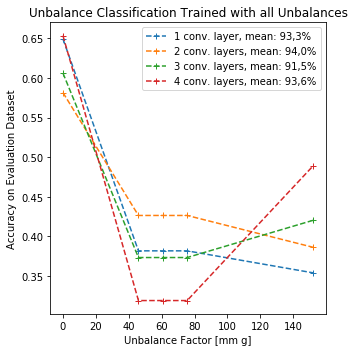

In [22]:
fig=plt.figure(figsize=(5,5))
ax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[0,:], label="1 conv. layer, mean: 93,3%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[1,:], label="2 conv. layers, mean: 94,0%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[2,:], label="3 conv. layers, mean: 91,5%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[3,:], label="4 conv. layers, mean: 93,6%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend()
plt.tight_layout()
plt.show()

## Rotation Speed Dependent Evaluation

In [23]:
from tensorflow.keras.models import load_model

model1 = load_model(f"{model_path}/cnn_1_layers.h5")
model2 = load_model(f"{model_path}/cnn_2_layers.h5")
model3 = load_model(f"{model_path}/cnn_3_layers.h5")
model4 = load_model(f"{model_path}/cnn_4_layers.h5")

In [24]:
def v2rpm(v):
    return 212*v + 209

from scipy.stats import mode
# 3s ramp up
fade_in = np.arange(0.0, 4.0, 4.0/(3*4096))
# complete voltage sweep
measurement_cycle = np.repeat(np.arange(4.0, 8.2, 0.1), 4096*20.0)
# measurement: start-up + 2 voltage sweeps
measurement = np.concatenate([fade_in, np.tile(measurement_cycle,3)]) 
# select the data as actually used
measurement1 = measurement[50000:]
measurement1 = measurement1[:int(len(measurement1)/4096)*4096].reshape(-1,4096)
voltages_measurement = mode(measurement1, axis=1)[0]
voltages_used = np.concatenate([voltages_measurement[:len(X_val_1)],
                                voltages_measurement[:len(X_val_2)],
                                voltages_measurement[:len(X_val_3)],
                                voltages_measurement[:len(X_val_4)],
                                voltages_measurement[:len(X_val_5)]])
rpms_used = v2rpm(voltages_used)

In [25]:
rpm_borders = np.arange(1050, 1975, 25)
errors_per_rpm_range1 = []
errors_per_rpm_range2 = []
errors_per_rpm_range3 = []
errors_per_rpm_range4 = []
for i in range(len(rpm_borders)-1):
    eval_inds = np.where((rpms_used>rpm_borders[i])&(rpms_used<rpm_borders[i+1]))[0]
    errors_per_rpm_range1.append(
        1-np.mean(np.abs(np.int32(model1.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range2.append(
        1-np.mean(np.abs(np.int32(model2.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range3.append(
        1-np.mean(np.abs(np.int32(model3.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range4.append(
        1-np.mean(np.abs(np.int32(model4.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))

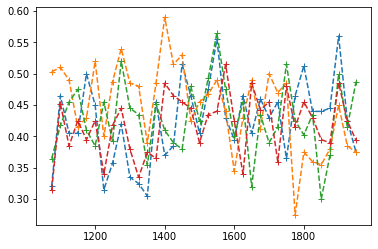

In [26]:
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, marker="+", ls="--")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, marker="+", ls="--")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, marker="+", ls="--")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, marker="+", ls="--")
plt.show()

## Pairwise Unbalance Training and Evaluation

In [27]:
X_dev = [X0, X1, X2, X3, X4]
y_dev = [y0, y1, y2, y3, y4]

X_val_separated = [X_val_1, X_val_2, X_val_3, X_val_4, X_val_5]
y_val_separated = [y0_val, y1_val, y2_val, y3_val, y4_val]

In [ ]:
for n_conv_layers in range(1,5):
    for dataset_i in range(4):
        X_dev_i = np.concatenate([X_dev[0], X_dev[dataset_i+1]])
        y_dev_i = np.concatenate([y_dev[0], y_dev[dataset_i+1]])
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])
        
        train_test_ratio = 0.9
        X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
            X_dev_i,y_dev_i, test_size = 1-train_test_ratio, random_state = 0)
        X_train_i = np.reshape(X_train_i, (X_train_i.shape[0], X_train_i.shape[1], 1))
        X_test_i = np.reshape(X_test_i, (X_test_i.shape[0], X_test_i.shape[1], 1))
        
        
        if not use_reference_models:
            weight_for_0 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==0]))
            weight_for_1 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==1]))
            class_weight = {0: weight_for_0, 1: weight_for_1}

            n_dense_units = 128
            dropout_rate = 0.0
            use_batch_normalization = True # [True, False]
            filter_size = 9 # [5,7,9]
            learning_rate = 0.0001
            n_epochs = 100 # [50,100,200]

            X_in = Input(shape=(X_train.shape[1],1))
            x = X_in
            for j in range(n_conv_layers):
                print(j)
                x = Conv1D(filters=(j+1)*10,
                           kernel_size=filter_size,
                           strides=1,
                           activation='linear',
                           kernel_initializer='he_uniform')(x)
                if use_batch_normalization:
                    x = BatchNormalization()(x)
                x = LeakyReLU(alpha=0.05)(x)
                x = MaxPooling1D(pool_size=5, strides=2)(x)
            x = Flatten()(x)
            x = Dense(units = n_dense_units, activation='linear')(x)
            x = ReLU()(x)
            x = Dropout(rate=dropout_rate)(x)
            X_out = Dense(units = 1, activation = 'sigmoid')(x)
            classifier = Model(X_in, X_out)

            best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers_dataset_pair_{dataset_i}.h5"
            checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                         verbose=1, save_best_only=True, mode='min')
            classifier.compile(optimizer = Adam(lr=learning_rate), loss = 'binary_crossentropy', 
                               metrics = ['accuracy'])
            classifier.summary()

            classifier.fit(X_train_i, y_train_i, epochs = n_epochs, batch_size = 128,
                       validation_data=(X_test_i, y_test_i), callbacks=[checkpoint], 
                           class_weight=class_weight)
        
        best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers_dataset_pair_{dataset_i}.h5"
        classifier = load_model(best_model_filepath)
        train_acc = classifier.evaluate(X_train_i, y_train_i)
        val_acc = classifier.evaluate(X_val_i, y_val_i)
        print(f"Layers: {layer_n}, dataset pair {dataset_i}")
        print(train_acc)
        print(val_acc)

W0427 22:32:50.831016 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


0
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 4088, 10)          100       
_________________________________________________________________
batch_normalization_11 (Batc (None, 4088, 10)          40        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4088, 10)          0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 2042, 10)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 20420)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               26

W0427 22:32:51.108178 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 11577 samples, validate on 1287 samples
Epoch 1/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.7302 - accuracy: 0.5059
Epoch 00001: val_loss improved from inf to 0.69289, saving model to ../models/cnn_1_layers_dataset_pair_0.h5
11577/11577 [==============================] - 7s 576us/sample - loss: 0.7301 - accuracy: 0.5051 - val_loss: 0.6929 - val_accuracy: 0.5206
Epoch 2/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5197
Epoch 00002: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 530us/sample - loss: 0.6926 - accuracy: 0.5196 - val_loss: 0.6936 - val_accuracy: 0.4911
Epoch 3/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.5352
Epoch 00003: val_loss did not improve from 0.69289
11577/11577 [==============================] - 7s 572us/sample - loss: 0.6883 - accuracy: 0.5351 - val_loss: 0.6938 - val_accuracy: 0.4848
Epoch 4/100
11520/11

Epoch 29/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6023 - accuracy: 0.6514
Epoch 00029: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 547us/sample - loss: 0.6026 - accuracy: 0.6508 - val_loss: 0.7722 - val_accuracy: 0.4833
Epoch 30/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.6539
Epoch 00030: val_loss did not improve from 0.69289
11577/11577 [==============================] - 7s 574us/sample - loss: 0.5972 - accuracy: 0.6538 - val_loss: 0.7553 - val_accuracy: 0.4911
Epoch 31/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.6758
Epoch 00031: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 544us/sample - loss: 0.5853 - accuracy: 0.6760 - val_loss: 0.7648 - val_accuracy: 0.4833
Epoch 32/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5824 - accuracy: 0.6718
Epoch 00032: val_loss 

11520/11577 [============================>.] - ETA: 0s - loss: 0.3047 - accuracy: 0.9186
Epoch 00057: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 532us/sample - loss: 0.3051 - accuracy: 0.9182 - val_loss: 0.9763 - val_accuracy: 0.4911
Epoch 58/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.9205
Epoch 00058: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 532us/sample - loss: 0.2963 - accuracy: 0.9204 - val_loss: 0.9620 - val_accuracy: 0.4825
Epoch 59/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.9385
Epoch 00059: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 513us/sample - loss: 0.2691 - accuracy: 0.9387 - val_loss: 1.0290 - val_accuracy: 0.4825
Epoch 60/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9447
Epoch 00060: val_loss did not impro

11520/11577 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.9991
Epoch 00085: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 525us/sample - loss: 0.0427 - accuracy: 0.9991 - val_loss: 1.5088 - val_accuracy: 0.5012
Epoch 86/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9991
Epoch 00086: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 495us/sample - loss: 0.0396 - accuracy: 0.9991 - val_loss: 1.5449 - val_accuracy: 0.4965
Epoch 87/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9994
Epoch 00087: val_loss did not improve from 0.69289
11577/11577 [==============================] - 6s 531us/sample - loss: 0.0365 - accuracy: 0.9994 - val_loss: 1.5151 - val_accuracy: 0.5058
Epoch 88/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9995
Epoch 00088: val_loss did not impro

W0427 22:43:02.458308 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


0
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4088, 10)          100       
_________________________________________________________________
batch_normalization_12 (Batc (None, 4088, 10)          40        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4088, 10)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2042, 10)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20420)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               26

W0427 22:43:02.744614 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 11577 samples, validate on 1287 samples
Epoch 1/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.7208 - accuracy: 0.5015
Epoch 00001: val_loss improved from inf to 0.69349, saving model to ../models/cnn_1_layers_dataset_pair_1.h5
11577/11577 [==============================] - 7s 576us/sample - loss: 0.7206 - accuracy: 0.5018 - val_loss: 0.6935 - val_accuracy: 0.4872
Epoch 2/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.5226
Epoch 00002: val_loss improved from 0.69349 to 0.69297, saving model to ../models/cnn_1_layers_dataset_pair_1.h5
11577/11577 [==============================] - 7s 595us/sample - loss: 0.6920 - accuracy: 0.5222 - val_loss: 0.6930 - val_accuracy: 0.5113
Epoch 3/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5300
Epoch 00003: val_loss did not improve from 0.69297
11577/11577 [==============================] - 7s 592us/sample - loss: 0.6890 - accuracy: 0.5298 

11520/11577 [============================>.] - ETA: 0s - loss: 0.6040 - accuracy: 0.6449
Epoch 00028: val_loss did not improve from 0.69239
11577/11577 [==============================] - 6s 549us/sample - loss: 0.6039 - accuracy: 0.6448 - val_loss: 0.7393 - val_accuracy: 0.5019
Epoch 29/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5909 - accuracy: 0.6683
Epoch 00029: val_loss did not improve from 0.69239
11577/11577 [==============================] - 7s 576us/sample - loss: 0.5910 - accuracy: 0.6681 - val_loss: 0.7382 - val_accuracy: 0.5074
Epoch 30/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5890 - accuracy: 0.6655
Epoch 00030: val_loss did not improve from 0.69239
11577/11577 [==============================] - 6s 531us/sample - loss: 0.5890 - accuracy: 0.6655 - val_loss: 0.7504 - val_accuracy: 0.5066
Epoch 31/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5823 - accuracy: 0.6739
Epoch 00031: val_loss did not impro

11520/11577 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.9344
Epoch 00056: val_loss did not improve from 0.69239
11577/11577 [==============================] - 6s 544us/sample - loss: 0.2825 - accuracy: 0.9345 - val_loss: 0.9764 - val_accuracy: 0.4949
Epoch 57/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9431
Epoch 00057: val_loss did not improve from 0.69239
11577/11577 [==============================] - 7s 585us/sample - loss: 0.2594 - accuracy: 0.9432 - val_loss: 0.9895 - val_accuracy: 0.5019
Epoch 58/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9520
Epoch 00058: val_loss did not improve from 0.69239
11577/11577 [==============================] - 7s 568us/sample - loss: 0.2445 - accuracy: 0.9519 - val_loss: 1.0141 - val_accuracy: 0.4903
Epoch 59/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9604
Epoch 00059: val_loss did not impro

11520/11577 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9989
Epoch 00084: val_loss did not improve from 0.69239
11577/11577 [==============================] - 7s 587us/sample - loss: 0.0396 - accuracy: 0.9989 - val_loss: 1.5223 - val_accuracy: 0.4903
Epoch 85/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9992
Epoch 00085: val_loss did not improve from 0.69239
11577/11577 [==============================] - 7s 570us/sample - loss: 0.0373 - accuracy: 0.9992 - val_loss: 1.5780 - val_accuracy: 0.4926
Epoch 86/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9991
Epoch 00086: val_loss did not improve from 0.69239
11577/11577 [==============================] - 7s 563us/sample - loss: 0.0347 - accuracy: 0.9991 - val_loss: 1.5404 - val_accuracy: 0.5035
Epoch 87/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9994
Epoch 00087: val_loss did not impro

W0427 22:54:32.180276 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


0
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4088, 10)          100       
_________________________________________________________________
batch_normalization_13 (Batc (None, 4088, 10)          40        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4088, 10)          0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 2042, 10)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 20420)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               26

W0427 22:54:32.470661 139967979775808 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 11577 samples, validate on 1287 samples
Epoch 1/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.7185 - accuracy: 0.4974
Epoch 00001: val_loss improved from inf to 0.69318, saving model to ../models/cnn_1_layers_dataset_pair_2.h5
11577/11577 [==============================] - 7s 581us/sample - loss: 0.7184 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5198
Epoch 2/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.4979
Epoch 00002: val_loss did not improve from 0.69318
11577/11577 [==============================] - 7s 576us/sample - loss: 0.6931 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4771
Epoch 3/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5037
Epoch 00003: val_loss did not improve from 0.69318
11577/11577 [==============================] - 7s 571us/sample - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6935 - val_accuracy: 0.4740
Epoch 4/100
11520/11

Epoch 29/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.5964
Epoch 00029: val_loss did not improve from 0.69315
11577/11577 [==============================] - 7s 636us/sample - loss: 0.6603 - accuracy: 0.5969 - val_loss: 0.7066 - val_accuracy: 0.5113
Epoch 30/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6567 - accuracy: 0.6039
Epoch 00030: val_loss did not improve from 0.69315
11577/11577 [==============================] - 7s 584us/sample - loss: 0.6565 - accuracy: 0.6040 - val_loss: 0.7158 - val_accuracy: 0.5027
Epoch 31/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6535 - accuracy: 0.6028
Epoch 00031: val_loss did not improve from 0.69315
11577/11577 [==============================] - 7s 585us/sample - loss: 0.6535 - accuracy: 0.6027 - val_loss: 0.7080 - val_accuracy: 0.5159
Epoch 32/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.5986
Epoch 00032: val_loss 

11520/11577 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.6796
Epoch 00057: val_loss did not improve from 0.69315
11577/11577 [==============================] - 6s 551us/sample - loss: 0.5830 - accuracy: 0.6798 - val_loss: 0.7477 - val_accuracy: 0.4918
Epoch 58/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5794 - accuracy: 0.6839
Epoch 00058: val_loss did not improve from 0.69315
11577/11577 [==============================] - 7s 592us/sample - loss: 0.5794 - accuracy: 0.6844 - val_loss: 0.7539 - val_accuracy: 0.4942
Epoch 59/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5760 - accuracy: 0.6874
Epoch 00059: val_loss did not improve from 0.69315
11577/11577 [==============================] - 7s 603us/sample - loss: 0.5759 - accuracy: 0.6878 - val_loss: 0.7811 - val_accuracy: 0.4810
Epoch 60/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.5759 - accuracy: 0.6845
Epoch 00060: val_loss did not impro

11520/11577 [============================>.] - ETA: 0s - loss: 0.4869 - accuracy: 0.7499
Epoch 00085: val_loss did not improve from 0.69315
11577/11577 [==============================] - 7s 569us/sample - loss: 0.4872 - accuracy: 0.7496 - val_loss: 0.8450 - val_accuracy: 0.4895
Epoch 86/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.4833 - accuracy: 0.7571
Epoch 00086: val_loss did not improve from 0.69315
11577/11577 [==============================] - 6s 561us/sample - loss: 0.4834 - accuracy: 0.7571 - val_loss: 0.8339 - val_accuracy: 0.4911
Epoch 87/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.4820 - accuracy: 0.7595
Epoch 00087: val_loss did not improve from 0.69315
11577/11577 [==============================] - 7s 593us/sample - loss: 0.4821 - accuracy: 0.7594 - val_loss: 0.8388 - val_accuracy: 0.4872
Epoch 88/100
11520/11577 [============================>.] - ETA: 0s - loss: 0.4781 - accuracy: 0.7589
Epoch 00088: val_loss did not impro

In [54]:
accuracies_single = []
for layer_n in range(1,5):
    accuracies_layer_i = []
    for dataset_i in range(4):
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])
        filepath = f"cnn_{layer_n}_layers_etfa_dataset_pair_{dataset_i}.h5"
        model_i = load_model(filepath)
        accuracies_layer_i.append(model_i.evaluate(X_val_i, y_val_i)[1])
    accuracies_single.append(accuracies_layer_i)
accuracies_single = np.array(accuracies_single)

3345/3345 [==============================] - 5s 1ms/sample - loss: 0.0116 - acc: 0.9976


In [55]:
np.mean(accuracies_single, axis=1)

array([0.7271022 , 0.79010403, 0.7231542 , 0.82241404], dtype=float32)

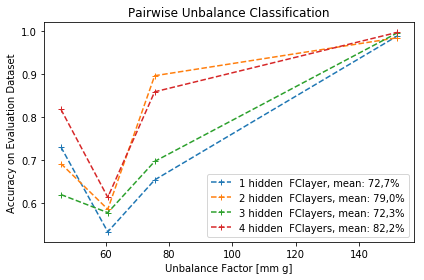

In [58]:
fig=plt.figure()
ax1=plt.subplot(111, title = "Pairwise Unbalance Classification")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances[1:], accuracies_single[0,:], 
         label="1 hidden  FClayer, mean: 72,7%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[1,:], 
         label="2 hidden  FClayers, mean: 79,0%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[2,:], 
         label="3 hidden  FClayers, mean: 72,3%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[3,:], 
         label="4 hidden  FClayers, mean: 82,2%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend()
plt.tight_layout()
plt.show()

## Plotting all Experiments

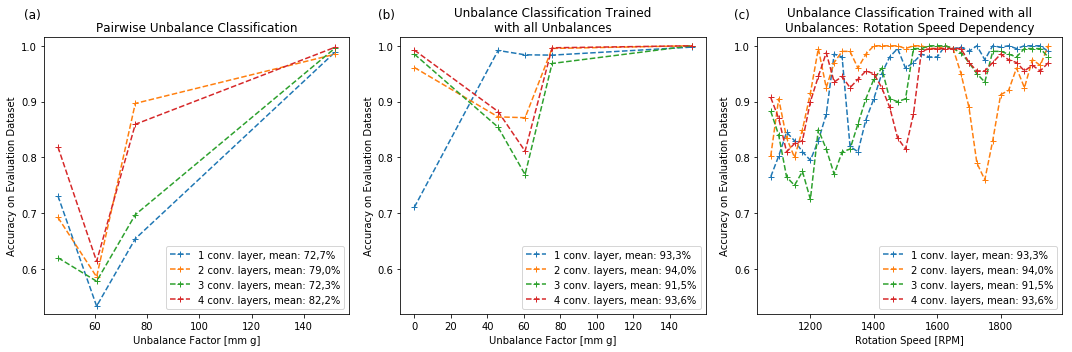

In [73]:
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot(132, title = "Unbalance Classification Trained\nwith all Unbalances")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[0,:], 
         label="1 conv. layer, mean: 93,3%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[1,:], 
         label="2 conv. layers, mean: 94,0%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[2,:], 
         label="3 conv. layers, mean: 91,5%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[3,:], 
         label="4 conv. layers, mean: 93,6%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.ylim([0.52, 1.015])
plt.legend(loc="lower right")
ax1.text(-20, 1.05,"(b)", fontsize=12)
ax2=plt.subplot(131, title = "Pairwise Unbalance Classification")
ax2.plot(1e6*unbalances[1:], accuracies_single[0,:], 
         label="1 conv. layer, mean: 72,7%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies_single[1,:], 
         label="2 conv. layers, mean: 79,0%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies_single[2,:], 
         label="3 conv. layers, mean: 72,3%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies_single[3,:], 
         label="4 conv. layers, mean: 82,2%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.ylim([0.52, 1.015])
plt.legend()
ax2.text(33, 1.05,"(a)", fontsize=12)
ax3 = plt.subplot(133, title="Unbalance Classification Trained with all\nUnbalances: Rotation Speed Dependency")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, 
         label="1 conv. layer, mean: 93,3%", marker="+", ls="--")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, 
         label="2 conv. layers, mean: 94,0%", marker="+", ls="--")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, 
         label="3 conv. layers, mean: 91,5%", marker="+", ls="--")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, 
         label="4 conv. layers, mean: 93,6%", marker="+", ls="--")

plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Rotation Speed [RPM]")
plt.ylim([0.52, 1.015])
plt.legend(loc="lower right")
ax3.text(960, 1.05,"(c)", fontsize=12)
plt.tight_layout()
plt.show()